In [ ]:
import os
from PIL import Image
import json
import os
import cv2
import fiftyone.zoo as foz
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import torchvision
from skimage.io import imread
from skimage.transform import resize
import shutil
%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Using this code you can choose any classes for the dataset and soon get dataset with masks saved at any convenient place

In [ ]:
%time

from six import class_types
dataset = foz.load_zoo_dataset(
    "coco-2017",
    label_types=["segmentations"],
    num_workers = 2,
    classes = ['person','cat','dog']
)

corrupted = {}
corrs = 0
MODES = ['validation', 'train']
train = []
validation = []

for mode in MODES:
  SAVED_PATH = f'/content/new_dataset/{mode}'
  print(mode,'part')
  coco = COCO(f'/content/original/root/fiftyone/coco-2017/{mode}/labels.json')

  os.mkdir(SAVED_PATH)
  img_dir = f'/content/original/root/fiftyone/coco-2017/{mode}/data'
  for index, file in tqdm(zip([int(x[:-4]) for x in os.listdir(img_dir)], os.listdir(img_dir))):  
    image_id = index
    img = coco.imgs[image_id]
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    if len(anns) == 0:
      os.remove(img_dir + '/' + str(index) + '.jpg')
      corrs +=1
    else:
      mask = coco.annToMask(anns[0])
      for i in range(len(anns)):
          mask += coco.annToMask(anns[i])
      image_mask = Image.fromarray(mask*255).convert('L')

      os.mkdir(os.path.join(SAVED_PATH,f'{index}'))

      os.mkdir(os.path.join(SAVED_PATH,f'{index}/mask'))
      image_mask.save(os.path.join(SAVED_PATH,f'{index}_mask.jpg'))
      
      
      os.mkdir(os.path.join(SAVED_PATH,f'{index}/orig'))
      new_dir_orig = os.path.join(SAVED_PATH,f'{index}/orig')

      shutil.copy(f'{img_dir}/{file}', f'{new_dir_orig}/{file}')

In [ ]:
train_dir = '/content/dataset/content/new_dataset/train'
val_dir = '/content/dataset/content/new_dataset/validation'

This function is for making dataloader. Also you can point out a count of images as resourses are restricted

In [ ]:
def data_create(name_dir, count):
  images = []
  masks = []
  for root, dirs, files in os.walk(name_dir):
      
      if root.endswith('orig'):

          images.append(imread(os.path.join(root, files[0])))
      if root.endswith('mask'):

          masks.append(imread(os.path.join(root, files[0])))

      if len(images) == len(masks) == count:
        break
  size = (256, 256)
  X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
  Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

  for num, x in enumerate(X):
    if x.shape != (256,256,3):
      X.pop(num)
      Y.pop(num)
  X = np.array(X, np.float32)
  Y = np.array(Y, np.float32)

  data = DataLoader(list(zip(np.rollaxis(X,3,1), np.rollaxis(Y,1,1))), batch_size=16, shuffle=False)
  
  return data

In [ ]:
data_val = data_create(val_dir,20)

In [ ]:
X, Y = next(iter(data_val))

In [ ]:
index = np.random.choice(16,5)

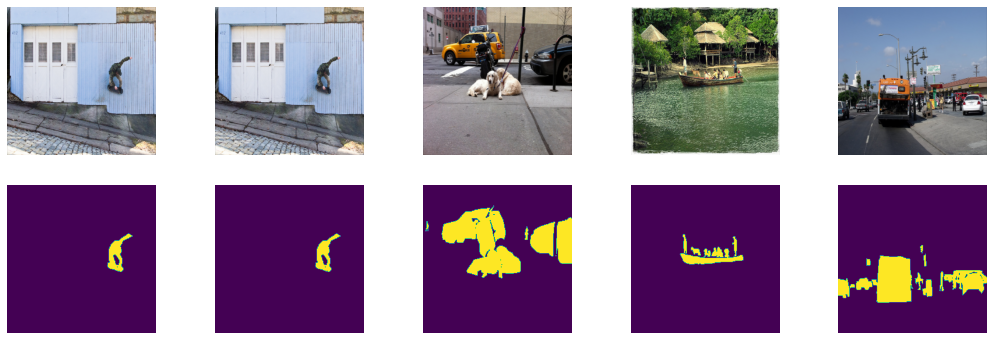

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for num, i in zip(index,range(5)):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(X[num].numpy().transpose(1,2,0))

    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(Y[num])
plt.show();

Function for IOU metric

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2)) 
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    
    return iou

The best quality was gor using BCELoss

In [ ]:
def bce_loss(y_pred, y_real):
  epsilon = 1*1e-20
  y_real = y_real.view(-1)
  y_pred = y_pred.view(-1)
  return  -1 *torch.mean(y_real * torch.log(torch.sigmoid(y_pred) + epsilon) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) +epsilon))


The function to estimate result

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0

    for X_batch, Y_label in data:
      Y_label = Y_label.unsqueeze(1)
      X_batch, Y_label = X_batch.to(device),Y_label.to(device)
      Y_pred = model(X_batch)['out']
    
      Y_pred = torch.where(torch.sigmoid(Y_pred) > 0.5, 1, 0)
      scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
def train(model, opt, scheduler, loss_fn, epochs):

    result = {}
    train_dir = '/content/dataset/content/new_dataset/train'
    val_dir = '/content/dataset/content/new_dataset/validation'

    data_val = data_create(val_dir,20)
    X_val, Y_val = next(iter(data_val))
    Y_val = Y_val.unsqueeze(1)
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)
    losses = []
    losses.append(1)
    best_score = 0
    score_val = []
    score_tr = []

    for epoch in range(epochs):

        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        model.train()  
#Train dataloader updates every 10 epohs. This action allows decreasing overlearning and accelerating time learning
        if epoch % 10 == 0:
          data_tr = data_create(train_dir, 1000)
        for X_batch, Y_batch in tqdm(data_tr):
   
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.unsqueeze(1)
            Y_batch = Y_batch.to(device)
            
            # set parameter gradients   to zero
            opt.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
              Y_pred = model(X_batch)['out']
           

              loss = loss_fn(Y_pred, Y_batch)

              loss.backward() 
              opt.step() 

            avg_loss += loss / len(data_tr)

        scheduler.step()

        print('loss: %f' % avg_loss)
    
        losses.append(float(avg_loss))

        iou_val = score_model(model, iou_pytorch, data_val)
        score_val.append(iou_val)
        if best_score < iou_val:
          best_score = iou_val
          torch.save( model.state_dict(),'./')

        score_tr.append(score_model(model, iou_pytorch, data_tr))
        print(f'train: {score_tr[-1]}, val: {score_val[-1]}')
        model.eval()
        Y_hat = model(X_val)['out'].detach().to('cpu')


        
        for k in range(3):
            plt.subplot(3, 3, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 3, k+4)
            plt.imshow(Y_hat[k,0].cpu().numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 3, k+7)
            plt.imshow(Y_val[k,0].cpu().numpy(), cmap='gray')
            plt.title('Groung truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    result['losses'] = losses[1:]
    result['score_val'] = score_val
    result['score_tr'] = score_tr


    return result

In [ ]:
torch.manual_seed(17)

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101


In [ ]:
model = deeplabv3_resnet101(pretrained=False,num_classes = 1)

In [ ]:
model = model.to(device)

In [ ]:
max_epochs = 30
optimaizer = optim.Adam(model.parameters(),lr = 7e-5)
sheduler = optim.lr_scheduler.StepLR(optimaizer, 4, gamma = 0.8)
results = train(model, optimaizer, sheduler,  bce_loss, max_epochs)